In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas_profiling
from pandas_profiling.utils.cache import cache_file

# 1. BLS Salary Data

In [2]:
# Import salary information for occupations for all areas into a dataframe
salary_df = pd.read_excel('../data/raw/MSA_M2020_dl.xlsx', sheet_name = 'MSA_M2020_dl')

## 1.1 Explore Salary Data

In [3]:
salary_df.head()

,AREA,AREA_TITLE,AREA_TYPE,PRIM_STATE,NAICS,NAICS_TITLE,I_GROUP,OWN_CODE,OCC_CODE,OCC_TITLE,...,H_MEDIAN,H_PCT75,H_PCT90,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90,ANNUAL,HOURLY
0,10180,"Abilene, TX",4,TX,0,Cross-industry,cross-industry,1235,00-0000,All Occupations,...,16.41,24.82,36.23,18990,23710,34130,51620,75370,NaN,NaN
1,10180,"Abilene, TX",4,TX,0,Cross-industry,cross-industry,1235,11-0000,Management Occupations,...,36.37,51.68,73.88,36150,55620,75640,107500,153670,NaN,NaN
2,10180,"Abilene, TX",4,TX,0,Cross-industry,cross-industry,1235,11-1021,General and Operations Managers,...,32.96,50.11,72.93,26350,49960,68550,104230,151700,NaN,NaN
3,10180,"Abilene, TX",4,TX,0,Cross-industry,cross-industry,1235,11-2022,Sales Managers,...,52.41,68.01,#,54560,74680,109000,141460,#,NaN,NaN
4,10180,"Abilene, TX",4,TX,0,Cross-industry,cross-industry,1235,11-2030,Public Relations and Fundraising Managers,...,36.24,41.23,83.81,59710,68180,75380,85760,174320,NaN,NaN


In [4]:
salary_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140051 entries, 0 to 140050
Data columns (total 31 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   AREA          140051 non-null  int64  
 1   AREA_TITLE    140051 non-null  object 
 2   AREA_TYPE     140051 non-null  int64  
 3   PRIM_STATE    140051 non-null  object 
 4   NAICS         140051 non-null  int64  
 5   NAICS_TITLE   140051 non-null  object 
 6   I_GROUP       140051 non-null  object 
 7   OWN_CODE      140051 non-null  int64  
 8   OCC_CODE      140051 non-null  object 
 9   OCC_TITLE     140051 non-null  object 
 10  O_GROUP       140051 non-null  object 
 11  TOT_EMP       140051 non-null  object 
 12  EMP_PRSE      140051 non-null  object 
 13  JOBS_1000     140051 non-null  object 
 14  LOC_QUOTIENT  140051 non-null  object 
 15  PCT_TOTAL     0 non-null       float64
 16  H_MEAN        140051 non-null  object 
 17  A_MEAN        140051 non-null  object 
 18  MEAN

### 1.1.1 Preliminary Cleaning

**Missing salary values for some occupations with wage equal to or greater than \\$208,000 a year**

\*  = indicates that a wage estimate is not available	
\**  = indicates that an employment estimate is not available	
\#  = indicates a wage equal to or greater than \\$100 per hour or $208,000 per year 	

In [5]:
# Occupations that make more than $208,000 a year/$100 an hour
salary_df['OCC_TITLE'][(salary_df['H_MEAN']=='#') | (salary_df['A_MEAN']=='#')].unique()

array(['Surgeons, Except Ophthalmologists', 'Anesthesiologists',
       'Physicians, All Other; and Ophthalmologists, Except Pediatric',
       'Obstetricians and Gynecologists',
       'General Internal Medicine Physicians',
       'Agents and Business Managers of Artists, Performers, and Athletes',
       'Dentists, General', 'Orthodontists', 'Psychiatrists',
       'Dentists, All Other Specialists', 'Family Medicine Physicians',
       'Oral and Maxillofacial Surgeons'], dtype=object)

In [6]:
# Replace annual and hourly mean for these occupations with the corresponding value, or should it be min? 
salary_df.loc[salary_df['A_MEAN'] == '#', 'A_MEAN'] = 208000

salary_df.loc[salary_df['H_MEAN'] == '#', 'H_MEAN'] = 100

**Incorrect data types**

From looking at the data and information about data types, there are several columns that have numerical values yet have non-numerical data types and must be converted to a numerica type.

In [7]:
# Remove dash from OCC_CODE before converting to numeric type
salary_df['OCC_CODE'] = salary_df['OCC_CODE'].str.replace('-','')
salary_df['OCC_CODE']

0         000000
1         110000
2         111021
3         112022
4         112030
           ...  
140046    537063
140047    537064
140048    537065
140049    537081
140050    537199
Name: OCC_CODE, Length: 140051, dtype: object

In [8]:
# List of fields to convert to numeric type
convert_to_float = ['OCC_CODE', 'TOT_EMP', 'EMP_PRSE', 'JOBS_1000', 'LOC_QUOTIENT', 'H_MEAN',
        'A_MEAN','MEAN_PRSE', 'H_PCT10', 'H_PCT25', 'H_MEDIAN', 'H_PCT75',
        'H_PCT90', 'A_PCT10', 'A_PCT25', 'A_MEDIAN', 'A_PCT75', 'A_PCT90']

# Convert to numeric type
salary_df[convert_to_float] = salary_df[convert_to_float].apply(pd.to_numeric, errors='coerce')
salary_df.dtypes

AREA              int64
AREA_TITLE       object
AREA_TYPE         int64
PRIM_STATE       object
NAICS             int64
NAICS_TITLE      object
I_GROUP          object
OWN_CODE          int64
OCC_CODE          int64
OCC_TITLE        object
O_GROUP          object
TOT_EMP         float64
EMP_PRSE        float64
JOBS_1000       float64
LOC_QUOTIENT    float64
PCT_TOTAL       float64
H_MEAN          float64
A_MEAN          float64
MEAN_PRSE       float64
H_PCT10         float64
H_PCT25         float64
H_MEDIAN        float64
H_PCT75         float64
H_PCT90         float64
A_PCT10         float64
A_PCT25         float64
A_MEDIAN        float64
A_PCT75         float64
A_PCT90         float64
ANNUAL           object
HOURLY           object
dtype: object

### 1.1.2 Salary data profile report

In [9]:
# Run a profile roport
profile_report = salary_df.profile_report(html={'style': {'full_width': True}})
#profile_report.to_file("../reports/bls.html")

profile_report.to_widgets()

**Drop columns not relevent to our problem statement**

The unsupported column 'PCT_TOTAL' appears to only have null values, we will drop it. AREA_TYPE, NAICS, NAICS_TITLE, I_GROUP, and OWN_CODE each only contain a single value (constant) for all rows and don't give us any information on differenciating between the rows. So I'll drop those as well right away. 

HOURLY and ANNUAL are missing over 99 and 95 percent respectively.
The fields HOURLY and ANNUL are defined as follows:

    annual - Contains "TRUE" if only annual wages are released. The OEWS program releases only annual wages for some occupations that typically work fewer than 2,080 hours per year, but are paid on an annual basis, such as teachers, pilots, and athletes.

    hourly - Contains "TRUE" if only hourly wages are released. The OEWS program releases only hourly wages for some occupations that typically work fewer than 2,080 hours per year and are paid on an hourly basis, such as actors, dancers, and musicians and singers.

The HOURLY seems relevent to only a few occuptions (only 215, and less than 0.2 percent). ANNUAL has more values (7,199) yet it is still missing nearly 95 percent of it's values. 58 unique occupation titles have a non_null value for ANNUAL. Should we keep these columns for now? Our problem statement is interested in total income of each occupation for cities around the country and the skill base that affects the income. Whether the income is reported only annually or hourly is probably not relevent! Looks like there are only 4 occupation titles this column applies to. I feel safe dropping it. There is a hardly any information here.

In [9]:
# Occupations where their HOURLY value IS reported
hourly_missing = salary_df[salary_df['HOURLY'].notna()].groupby('OCC_TITLE')
hourly_missing['OCC_TITLE'].nunique()

OCC_TITLE
Actors                                                                   1
Dancers                                                                  1
Miscellaneous Entertainers and Performers, Sports and Related Workers    1
Musicians and Singers                                                    1
Name: OCC_TITLE, dtype: int64

In [10]:
# Occupations where their ANNUAL value IS reported
annual_missing = salary_df[salary_df['ANNUAL'].notna()].groupby('OCC_TITLE')
annual_missing['OCC_TITLE'].nunique()

OCC_TITLE
Agricultural Sciences Teachers, Postsecondary                               1
Airline Pilots, Copilots, and Flight Engineers                              1
Anthropology and Archeology Teachers, Postsecondary                         1
Architecture Teachers, Postsecondary                                        1
Area, Ethnic, and Cultural Studies Teachers, Postsecondary                  1
Art, Drama, and Music Teachers, Postsecondary                               1
Athletes and Sports Competitors                                             1
Athletic Trainers                                                           1
Atmospheric, Earth, Marine, and Space Sciences Teachers, Postsecondary      1
Biological Science Teachers, Postsecondary                                  1
Business Teachers, Postsecondary                                            1
Career/Technical Education Teachers, Middle School                          1
Career/Technical Education Teachers, Secondary School 

These are mostly teaching occupations, with pilots, athletes legislators having most of the remaining occupations.

In [11]:
# How many distinct occupation titles are not null for ANNUAL? 
annual_missing['OCC_TITLE'].nunique().sum()

58

In [12]:
# Drop non-relevent columns
salary_df = salary_df.drop(columns=['AREA_TYPE', 'NAICS', 'NAICS_TITLE', 'I_GROUP', 'OWN_CODE', 'PCT_TOTAL', 'ANNUAL', 'HOURLY'])
salary_df.columns

Index(['AREA', 'AREA_TITLE', 'PRIM_STATE', 'OCC_CODE', 'OCC_TITLE', 'O_GROUP',
       'TOT_EMP', 'EMP_PRSE', 'JOBS_1000', 'LOC_QUOTIENT', 'H_MEAN', 'A_MEAN',
       'MEAN_PRSE', 'H_PCT10', 'H_PCT25', 'H_MEDIAN', 'H_PCT75', 'H_PCT90',
       'A_PCT10', 'A_PCT25', 'A_MEDIAN', 'A_PCT75', 'A_PCT90'],
      dtype='object')

## 1.2 Categorical Variables

In [13]:
# Select categorical variable types
salary_df.select_dtypes('object')

,AREA_TITLE,PRIM_STATE,OCC_TITLE,O_GROUP
0,"Abilene, TX",TX,All Occupations,total
1,"Abilene, TX",TX,Management Occupations,major
2,"Abilene, TX",TX,General and Operations Managers,detailed
3,"Abilene, TX",TX,Sales Managers,detailed
4,"Abilene, TX",TX,Public Relations and Fundraising Managers,detailed
...,...,...,...,...
140046,"Worcester, MA-CT",MA,Machine Feeders and Offbearers,detailed
140047,"Worcester, MA-CT",MA,"Packers and Packagers, Hand",detailed
140048,"Worcester, MA-CT",MA,Stockers and Order Fillers,detailed
140049,"Worcester, MA-CT",MA,Refuse and Recyclable Material Collectors,detailed


From the report we can see there are no missing values for our categorical variables.

### 1.2.1 Area and state

In [14]:
# Unique states
print(salary_df['PRIM_STATE'].nunique()) 
print(salary_df['PRIM_STATE'].unique()) 
salary_df['PRIM_STATE'].value_counts().head() 

52
['TX' 'PR' 'OH' 'GA' 'OR' 'NY' 'NM' 'LA' 'PA' 'IA' 'AK' 'MI' 'AL' 'WI'
 'NC' 'NJ' 'CA' 'MD' 'WV' 'WA' 'MT' 'ND' 'VA' 'IL' 'IN' 'ID' 'CO' 'KY'
 'FL' 'MO' 'NV' 'WY' 'SC' 'TN' 'DE' 'MN' 'OK' 'AR' 'AZ' 'NE' 'MS' 'HI'
 'KS' 'UT' 'SD' 'DC' 'ME' 'MA' 'CT' 'VT' 'NH' 'RI']


CA    10713
TX     9320
FL     8318
PA     6406
NC     5420
Name: PRIM_STATE, dtype: int64

In [15]:
# How many unique AREA_TITLES?
print(salary_df['AREA_TITLE'].nunique())
salary_df['AREA_TITLE'].value_counts()

396


New York-Newark-Jersey City, NY-NJ-PA          756
Los Angeles-Long Beach-Anaheim, CA             741
Chicago-Naperville-Elgin, IL-IN-WI             741
Philadelphia-Camden-Wilmington, PA-NJ-DE-MD    716
Boston-Cambridge-Nashua, MA-NH                 715
                                              ... 
Mayaguez, PR                                   147
Arecibo, PR                                    140
Hinesville, GA                                 115
San German, PR                                  98
Guayama, PR                                     67
Name: AREA_TITLE, Length: 396, dtype: int64

396 unique AREA_TITLE (same as AREA which is code for each AREA_TITLE). But there are state labels included. There are multiple state labels included for metropolitan areas. 

In [16]:
# AREA_TITLE vs. state lables
area_split = salary_df['AREA_TITLE'].str.split(', ', expand=True)
area_split[1].unique()

array(['TX', 'PR', 'OH', 'GA', 'OR', 'NY', 'NM', 'LA', 'PA-NJ', 'PA',
       'IA', 'AK', 'MI', 'AL', 'WI', 'NC', 'NJ', 'GA-SC', 'CA', 'MD',
       'WV', 'WA', 'MT', 'ND', 'VA', 'IL', 'IN', 'ID', 'CO', 'KY', 'FL',
       'MO-IL', 'NV', 'WY', 'SC', 'NC-SC', 'TN-GA', 'IL-IN-WI',
       'OH-KY-IN', 'TN-KY', 'TN', 'MO', 'GA-AL', 'MD-WV', 'IA-IL', 'DE',
       'MN-WI', 'OK', 'IN-KY', 'ND-MN', 'AR-MO', 'AZ', 'AR-OK', 'NE',
       'MS', 'AR', 'WV-KY-OH', 'HI', 'MO-KS', 'TN-VA', 'WI-MN', 'KS',
       'ID-WA', 'UT-ID', 'KY-IN', 'MN', 'TN-MS-AR', 'SC-NC', 'NY-NJ-PA',
       'UT', 'NE-IA', 'PA-NJ-DE-MD', 'OR-WA', 'SD', 'MD-DE', 'IA-NE-SD',
       'IN-MI', 'TX-AR', 'VA-NC', 'DC-VA-MD-WV', 'WV-OH', 'VA-WV',
       'OH-PA', 'ME', 'MA', 'MA-NH', 'CT', 'VT', 'NH-ME', 'NH', 'CT-RI',
       'RI-MA', 'MA-CT'], dtype=object)

In [17]:
# Separate area title from state labels in salary_df
salary_df['AREA_TITLE'] = area_split[0]
salary_df.head()

,AREA,AREA_TITLE,PRIM_STATE,OCC_CODE,OCC_TITLE,O_GROUP,TOT_EMP,EMP_PRSE,JOBS_1000,LOC_QUOTIENT,...,H_PCT10,H_PCT25,H_MEDIAN,H_PCT75,H_PCT90,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90
0,10180,Abilene,TX,0,All Occupations,total,66060.0,1.9,1000.000,1.00,...,9.13,11.40,16.41,24.82,36.23,18990.0,23710.0,34130.0,51620.0,75370.0
1,10180,Abilene,TX,110000,Management Occupations,major,2910.0,4.5,44.068,0.77,...,17.38,26.74,36.37,51.68,73.88,36150.0,55620.0,75640.0,107500.0,153670.0
2,10180,Abilene,TX,111021,General and Operations Managers,detailed,1320.0,7.4,20.036,1.19,...,12.67,24.02,32.96,50.11,72.93,26350.0,49960.0,68550.0,104230.0,151700.0
3,10180,Abilene,TX,112022,Sales Managers,detailed,90.0,18.5,1.317,0.47,...,26.23,35.90,52.41,68.01,NaN,54560.0,74680.0,109000.0,141460.0,NaN
4,10180,Abilene,TX,112030,Public Relations and Fundraising Managers,detailed,40.0,31.5,0.549,0.94,...,28.71,32.78,36.24,41.23,83.81,59710.0,68180.0,75380.0,85760.0,174320.0


Another observation about AREA_TITLE: most common values appear to be for metropolitan areas which makes sense since they are highly concentrated and more jobs are available in these areas. Also the highest value count for occupations per state is from California which should also make senese since it represents the most populous state. 

### 1.2.2 Occupation Titles and Groups

In [18]:
# Number of unique occupation titles
print(salary_df['OCC_TITLE'].nunique())
salary_df['OCC_TITLE'].value_counts()

808


Janitors and Cleaners, Except Maids and Housekeeping Cleaners    396
Installation, Maintenance, and Repair Occupations                396
Accountants and Auditors                                         396
First-Line Supervisors of Retail Sales Workers                   396
Transportation and Material Moving Occupations                   396
                                                                ... 
Refractory Materials Repairers, Except Brickmasons                 1
Nuclear Power Reactor Operators                                    1
Cooks, Private Household                                           1
Timing Device Assemblers and Adjusters                             1
Manufactured Building and Mobile Home Installers                   1
Name: OCC_TITLE, Length: 808, dtype: int64

There are 808 unique occupation titles the same as OCC_CODE which is good.

In [19]:
# O_GROUP 

salary_df['O_GROUP'].value_counts()

detailed    131010
major         8645
total          396
Name: O_GROUP, dtype: int64

O_GROUP - For most occupations, this field indicates the standard SOC major, minor, broad, and detailed levels, in addition to all-occupations totals. 

In [20]:
# Filter for the 'detailed' O_GROUP category to get rid of all values for aggregates of job types, then drop O_GROUP column
salary_df = salary_df[salary_df['O_GROUP'] == 'detailed'].reset_index(drop=True)
salary_df = salary_df.drop(columns=['O_GROUP'])
salary_df.columns

Index(['AREA', 'AREA_TITLE', 'PRIM_STATE', 'OCC_CODE', 'OCC_TITLE', 'TOT_EMP',
       'EMP_PRSE', 'JOBS_1000', 'LOC_QUOTIENT', 'H_MEAN', 'A_MEAN',
       'MEAN_PRSE', 'H_PCT10', 'H_PCT25', 'H_MEDIAN', 'H_PCT75', 'H_PCT90',
       'A_PCT10', 'A_PCT25', 'A_MEDIAN', 'A_PCT75', 'A_PCT90'],
      dtype='object')

## 1.3 Numerical Variables

### 1.3.1 Employment 

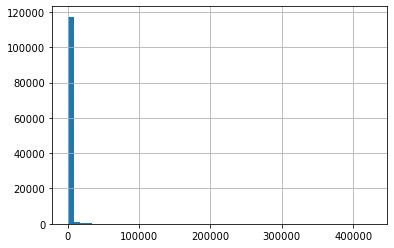

In [21]:
# TOT_EMP distribution
salary_df['TOT_EMP'].hist(bins=50);

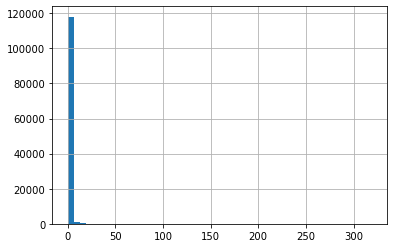

In [22]:
# LOC_QUOTIENT
salary_df['LOC_QUOTIENT'].hist(bins=50);

The LOC_QUOTIENT - represents the ratio of an occupation’s share of employment in a given area to that occupation’s share of employment in the U.S. as a whole. Only available for the state, metropolitan area, and nonmetropolitan area estimates; otherwise, this column is blank. A location quotient greater than one indicates the occupation has a higher share of employment than average, and a location quotient less than one indicates the occupation is less prevalent in the area than average.

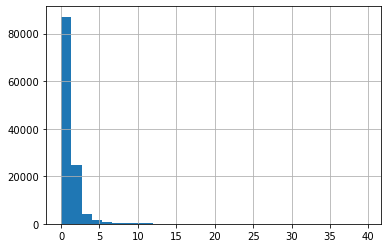

In [23]:
# Looking at location quotient distribution for values less than 40, to see what happens if we exclude really high values
salary_df['LOC_QUOTIENT'][salary_df['LOC_QUOTIENT'] < 40].hist(bins=30);

Really high, though rare location quotients are possible if the location has a high concentration of that occuption. 

In [24]:
# Let's look at the highest LOC_QUOTIENT values to see what occupation and area they represent
salary_df[['AREA_TITLE','PRIM_STATE','OCC_TITLE','LOC_QUOTIENT']][salary_df[
    'LOC_QUOTIENT'] > 100].sort_values('LOC_QUOTIENT',ascending=False).reset_index(drop=True)

,AREA_TITLE,PRIM_STATE,OCC_TITLE,LOC_QUOTIENT
0,Dalton,GA,"Textile Winding, Twisting, and Drawing Out Mac...",319.37
1,Dalton,GA,"Textile Knitting and Weaving Machine Setters, ...",218.17
2,Houma-Thibodaux,LA,Sailors and Marine Oilers,166.24
3,Wheeling,WV,"Roof Bolters, Mining",129.65
4,Bremerton-Silverdale,WA,"Layout Workers, Metal and Plastic",115.51
5,Dalton,GA,"Extruding and Forming Machine Setters, Operato...",113.63
6,San German,PR,Sewing Machine Operators,103.87
7,Midland,TX,"Service Unit Operators, Oil and Gas",102.66
8,Hickory-Lenoir-Morganton,NC,"Cutters and Trimmers, Hand",100.93
9,Hickory-Lenoir-Morganton,NC,Upholsterers,100.27


The relative standard error (RSE) is a measure of the reliability of a survey statistic. The smaller the relative standard error, the more precise the estimate.

Estimates for detailed occupations do not sum to the totals because the totals include occupations not shown separately. Estimates do not include self-employed workers.

Annual wages have been calculated by multiplying the hourly mean wage by a "year-round, full-time" hours figure of 2,080 hours; for those occupations where there is not an hourly wage published, the annual wage has been directly calculated from the reported survey data.

### 1.3.2 Target features

We are interested in income by occupation for cities and metropolitan areas. Which value are we interested in? For each annual and hourly income estimates, there are columns for mean, median, 10th, 25th, 75th, and 90th percentiles. 

The percentile wage estimate is the value of a wage below which a certain percent of workers fall. The median wage is the 50th percentile wage estimate—50 percent of workers earn less than the median and 50 percent of workers earn more than the median.

**Hourly mean and annual mean**

*Hourly mean* - Missing 6.6 percent; min = 8.32, max = 315830; IQR = 15.51; median = 22.94; Mean = 27.17

*Annual mean* - Missing 2 percent; min = 17300, max = 151.84; IQR = 33040; median = 48560; Mean = 57082

Both are skewed to the right which makes sense since the max value is so much larger than the median values. 

In [25]:
# When Hourly and annual mean are both null 
both_missing = salary_df[(salary_df['H_MEAN'].isnull()) & (salary_df['A_MEAN'].isnull())]
both_missing.isna().sum()

AREA               0
AREA_TITLE         0
PRIM_STATE         0
OCC_CODE           0
OCC_TITLE          0
TOT_EMP            0
EMP_PRSE           0
JOBS_1000          0
LOC_QUOTIENT       0
H_MEAN          2477
A_MEAN          2477
MEAN_PRSE       2477
H_PCT10         2477
H_PCT25         2477
H_MEDIAN        2477
H_PCT75         2477
H_PCT90         2477
A_PCT10         2477
A_PCT25         2477
A_MEDIAN        2477
A_PCT75         2477
A_PCT90         2477
dtype: int64

In [26]:
both_missing.shape

(2477, 22)

In [27]:
# Count and percent missing values
missing_counts = pd.concat([salary_df.isnull().sum(), 100 * salary_df.isnull().mean()], axis=1)
missing_counts.columns=['count', '%']
missing_counts.sort_values(by='count', ascending=False)

,count,%
H_PCT90,12944,9.880162
TOT_EMP,11582,8.840547
EMP_PRSE,11582,8.840547
JOBS_1000,11582,8.840547
LOC_QUOTIENT,11582,8.840547
H_PCT75,10841,8.274941
H_MEDIAN,10067,7.684146
H_PCT25,9458,7.219296
H_PCT10,9220,7.037631
H_MEAN,9087,6.936112


Of all the columns with income information, A_MEAN has the least number of values missing at 2 percent  or 2651 values.

In [28]:
# Do we have hourly information for any missing annual values?
annual_missing = salary_df[['OCC_TITLE','A_MEAN','H_MEAN']][(salary_df['A_MEAN'].isna()) & (salary_df['H_MEAN'].notna())]
annual_missing['OCC_TITLE'].value_counts()

Musicians and Singers                                                    74
Miscellaneous Entertainers and Performers, Sports and Related Workers    54
Actors                                                                   27
Dancers                                                                  19
Name: OCC_TITLE, dtype: int64

I will keep these for now. These are the occuptions that as mentioned before have hourly wages reported and work less than 2080 hours. May we have some way to deduce these values for the annual ones. But I will drop rows where both annual and hourly mean are missing (these rows are missing every income related information in all other columns as well).

In [29]:
# Drop rows where both A_MEAN AND H_MEAN missing
salary_df.drop(both_missing.index, inplace=True)

In [30]:
salary_df.shape

(128533, 22)

## 1.4 BLS Salary Dataframe

In [31]:
# Build the dataframe we are interested in: Area information and state, occupation code, title and hourly and annual means
salary = salary_df[['OCC_CODE', 'OCC_TITLE', 'AREA_TITLE', 'PRIM_STATE', 'A_MEAN', 'H_MEAN']]
salary = salary.rename(columns = {'OCC_CODE':'occ_code', 'OCC_TITLE':'occupation', 'AREA_TITLE':'location', 
                         'PRIM_STATE':'state', 'A_MEAN':'annual', 'H_MEAN':'hourly'})
salary = salary.set_index('occ_code')
salary.head()

,occupation,location,state,annual,hourly
occ_code,,,,,
111021,General and Operations Managers,Abilene,TX,83990.0,40.38
112022,Sales Managers,Abilene,TX,121020.0,58.18
112030,Public Relations and Fundraising Managers,Abilene,TX,95540.0,45.93
113010,Administrative Services and Facilities Managers,Abilene,TX,78600.0,37.79
113021,Computer and Information Systems Managers,Abilene,TX,123040.0,59.15


In [32]:
salary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 128533 entries, 111021 to 537199
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   occupation  128533 non-null  object 
 1   location    128533 non-null  object 
 2   state       128533 non-null  object 
 3   annual      128359 non-null  float64
 4   hourly      121923 non-null  float64
dtypes: float64(2), object(3)
memory usage: 5.9+ MB


In [33]:
# Percent missing annual wage
salary['annual'].isna().mean()*100

0.13537379505652244

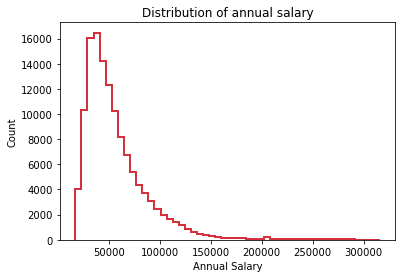

In [63]:
# Annual wage distriution
salary['annual'].hist(bins=50, color='#d4313c', histtype='step', linewidth = 2)
plt.xlabel('Annual Salary')
plt.ylabel('Count')
plt.title('Distribution of annual salary')
plt.grid(False);

In [36]:
# Percent missing hourly wage
salary['hourly'].isna().mean()*100

5.142648191515019

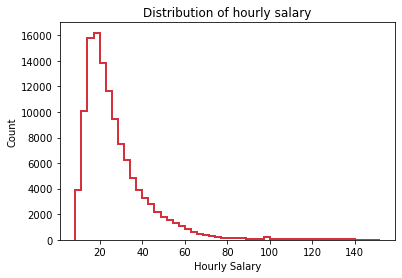

In [67]:
# Hourly wage distribution
salary['hourly'].hist(bins=50, color='#d4313c', histtype='step', linewidth = 2)
plt.xlabel('Hourly Salary')
plt.ylabel('Count')
plt.title('Distribution of hourly salary')
plt.grid(False);

In [45]:
# Salary dataframe summary statistics for annual and hourly wage
salary.describe().T

,count,mean,std,min,25%,50%,75%,max
annual,128359.0,57448.246948,32850.161783,17300.00,35820.00,48690.00,69030.00,315830.00
hourly,121923.0,27.336384,15.875471,8.32,17.05,22.96,32.61,151.84


# 2. O'NET Skills Data

In [46]:
#Read skills information for occupations into a dataframe
skills_df = pd.read_excel('../data/raw/Skills.xlsx')

## 2.1 Explore O'NET Data

In [47]:
skills_df.head()

,O*NET-SOC Code,Title,Element ID,Element Name,Scale ID,Scale Name,Data Value,N,Standard Error,Lower CI Bound,Upper CI Bound,Recommend Suppress,Not Relevant,Date,Domain Source
0,11-1011.00,Chief Executives,2.A.1.a,Reading Comprehension,IM,Importance,4.12,8.0,0.13,3.88,4.37,N,NaN,07/2014,Analyst
1,11-1011.00,Chief Executives,2.A.1.a,Reading Comprehension,LV,Level,4.75,8.0,0.16,4.43,5.07,N,N,07/2014,Analyst
2,11-1011.00,Chief Executives,2.A.1.b,Active Listening,IM,Importance,4.12,8.0,0.13,3.88,4.37,N,NaN,07/2014,Analyst
3,11-1011.00,Chief Executives,2.A.1.b,Active Listening,LV,Level,4.88,8.0,0.23,4.43,5.32,N,N,07/2014,Analyst
4,11-1011.00,Chief Executives,2.A.1.c,Writing,IM,Importance,4.00,8.0,0.00,4.00,4.00,N,NaN,07/2014,Analyst


In [48]:
skills_df.columns

Index(['O*NET-SOC Code', 'Title', 'Element ID', 'Element Name', 'Scale ID',
       'Scale Name', 'Data Value', 'N', 'Standard Error', 'Lower CI Bound',
       'Upper CI Bound', 'Recommend Suppress', 'Not Relevant', 'Date',
       'Domain Source'],
      dtype='object')

In [49]:
skills_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61110 entries, 0 to 61109
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   O*NET-SOC Code      61110 non-null  object 
 1   Title               61110 non-null  object 
 2   Element ID          61110 non-null  object 
 3   Element Name        61110 non-null  object 
 4   Scale ID            61110 non-null  object 
 5   Scale Name          61110 non-null  object 
 6   Data Value          61110 non-null  float64
 7   N                   57400 non-null  float64
 8   Standard Error      57400 non-null  float64
 9   Lower CI Bound      57400 non-null  float64
 10  Upper CI Bound      57400 non-null  float64
 11  Recommend Suppress  61110 non-null  object 
 12  Not Relevant        30555 non-null  object 
 13  Date                61110 non-null  object 
 14  Domain Source       61110 non-null  object 
dtypes: float64(5), object(10)
memory usage: 7.0+ MB


### 2.1.1 Column definitions

I'll be using the O\*Net code to join with the salary dataframe from BLS data above. According to their website: 

   "The O\*NET Database is in compliance with the current federal mandate to follow the Standard Occupational Classification (SOC). The O\*NET Database is the result of efforts by the U.S. Department of Labor to provide the nation with a new system of occupational information which is relevant to the ever-changing world of work. The O\*NET Database uses the basic 6-digit numerical coding structure of the SOC as its framework, adding a 2-digit extension (sequentially numbered beginning with ".01") to differentiate unique O\*NET occupations within the SOC system."

The level, importance and frequency scales each have a different range of possible scores. Ratings on Level were collected on a 0-7 scale, ratings on Importance were collected on a 1-5 scale, and ratings on Frequency were collected on a 1-4 scale. To make reports generated by O*NET OnLine more intuitively understandable to users, descriptor average ratings were standardized to a scale ranging from 0 to 100. The equation for conversion of original ratings to standardized scores is:

S = ( (O - L) / (H - L) ) * 100

where S is the standardized score, O is the original rating score on one of the three scales, L is the lowest possible score on the rating scale used, and H is the highest possible score on the rating scale used. For example, an original Importance rating score of 3 is converted to a standardized score of 50 (50 = [ [3 - 1] / [5 - 1] ] * 100). For another example, an original Level rating score of 5 is converted to a standardized score of 71 (71 = [ [5 - 0] / [7 - 0] ] * 100).

Element ID and Scale ID don't give us any more information than the Element Name and Scale Name columns so there is no need to keep them.

### 2.1.2 Rating Level Statistics

For each of the Ability domain and Skills domain elements, additional rating level statistics, such as Standard Error and data flags are included to help provide a description of the quality of the data values. The file has columns to represent these additional values.

* ***N*** is the sample size.

* ***Standard Error*** - Standard errors were calculated to provide an indication of each estimate’s precision. The standard error of the mean (SEM) is the standard deviation of the ratings across analysts divided by the square root of the number of analysts (i.e., eight). Statistics with large standard errors are generally considered less precise than those with small standard errors.

* ***Upper CI Bound and Lower CI Bound*** - The standard error of the mean (SEM) was used to define a range (confidence interval) around the estimate. The upper and lower bounds of the 95% confidence interval establish this range such that over a large number of sample estimates the probability is .95 that the population mean will be included in a confidence interval of this size. The upper bound of the confidence interval is calculated by taking the SEM and multiplying it by 1.96 and adding that number to the observed mean. The lower bound of the confidence interval is calculated by taking the SEM and multiplying it by 1.96 and subtracting that number from the observed mean.

* ***Recommend Suppress*** - Users are encouraged to use estimates exhibiting “low precision” with caution and for many applications users are advised to consider suppressing these estimates. Abilities and Skills estimates are considered to have low precision if the standard error is greater than .51. The value of .51 was selected as a suppression criterion because 1.0/1.96 = .5102. An SEM of >.51 means that the upper and lower bounds of the confidence interval are more than 1 scale point away from the observed mean.

* ***Not Relevant*** –The ability or skill level rating is identified as “not relevant” if 0, 1, or 2 analysts rated importance for that ability ≥ 2 (i.e., six or more analysts rated importance a 1). A value of “Y” indicates 0, 1, or 2 analysts rated importance ≥ 2. A value of “N” indicates more than 2 analysts rated importance ≥ 2. Users are encouraged to provide their end-users with an indication that the item level rating is “not relevant” rather than displaying the level value or displaying no level information.

I won't be working with these columns (at least not just yet?) so I am going to drop them in the final dataframe. Date and Domain Source will not be included either. 

## 2.2 Skills Dataframe

In [50]:
# Construct skills datafram from relevent columns, rename columns and set the O*Net code as the index
skills = skills_df[['O*NET-SOC Code', 'Title', 'Element Name', 'Scale Name', 'Data Value']]
skills = skills.rename(columns={'O*NET-SOC Code':'code', 'Title':'occupation', 'Element Name':'skill', 'Scale Name':
                                     'scale_name', 'Data Value':'scale_value'})
skills.set_index('code')

,occupation,skill,scale_name,scale_value
code,,,,
11-1011.00,Chief Executives,Reading Comprehension,Importance,4.12
11-1011.00,Chief Executives,Reading Comprehension,Level,4.75
11-1011.00,Chief Executives,Active Listening,Importance,4.12
11-1011.00,Chief Executives,Active Listening,Level,4.88
11-1011.00,Chief Executives,Writing,Importance,4.00
...,...,...,...,...
53-7121.00,"Tank Car, Truck, and Ship Loaders",Management of Financial Resources,Level,1.12
53-7121.00,"Tank Car, Truck, and Ship Loaders",Management of Material Resources,Importance,2.00
53-7121.00,"Tank Car, Truck, and Ship Loaders",Management of Material Resources,Level,1.88


In [51]:
# Clean O*NET-SOC Code column and convert to integer index so we can joing with the bls data
skills['code'] = skills['code'].str.replace('-','')
skills['code'] = skills['code'].str.split('.', expand=True)
skills['code'] = skills['code'].apply(pd.to_numeric)

skills = skills.set_index('code')
skills.head()

,occupation,skill,scale_name,scale_value
code,,,,
111011,Chief Executives,Reading Comprehension,Importance,4.12
111011,Chief Executives,Reading Comprehension,Level,4.75
111011,Chief Executives,Active Listening,Importance,4.12
111011,Chief Executives,Active Listening,Level,4.88
111011,Chief Executives,Writing,Importance,4.00


In [52]:
# Unique scale_name values
skills['scale_name'].unique()

array(['Importance', 'Level'], dtype=object)

In [53]:
# For now just get a df with only importance scale values and drop scale_name column and rename value column
skills = skills[skills['scale_name'] == 'Importance']
skills.drop(columns='scale_name', inplace=True)
skills.rename(columns={'scale_value':'importance'}, inplace=True)
skills.head()

,occupation,skill,importance
code,,,
111011,Chief Executives,Reading Comprehension,4.12
111011,Chief Executives,Active Listening,4.12
111011,Chief Executives,Writing,4.00
111011,Chief Executives,Speaking,4.38
111011,Chief Executives,Mathematics,3.25


# 3. Join Salary and Skills Dataframes

In [54]:
# Inner join
inner_join = skills.join(salary, lsuffix='_onet', rsuffix='_bls', how='inner')
inner_join.isna().sum()

occupation_onet         0
skill                   0
importance              0
occupation_bls          0
location                0
state                   0
annual               4200
hourly             186585
dtype: int64

In [55]:
inner_join.shape

(4778200, 8)

In [56]:
# Instances where joined occupations (based on SOC code) have different titles from each source
map_occupation = inner_join[['occupation_onet','occupation_bls']][inner_join['occupation_bls'] != inner_join['occupation_onet']].value_counts().reset_index()
map_occupation

,occupation_onet,occupation_bls,0
0,Baristas,Fast Food and Counter Workers,13860
1,Recycling and Reclamation Workers,"Laborers and Freight, Stock, and Material Move...",13790
2,Solar Energy Installation Managers,First-Line Supervisors of Construction Trades ...,13755
3,Investment Fund Managers,Financial Managers,13720
4,Treasurers and Controllers,Financial Managers,13720
...,...,...,...
96,Music Therapists,"Therapists, All Other",2030
97,Biofuels Processing Technicians,"Plant and System Operators, All Other",1855
98,Environmental Economists,Economists,1820
99,Robotics Technicians,Electro-Mechanical and Mechatronics Technologi...,1680


In [57]:
# Drop occupation_bls and keep the onet (more detailed) titles
salary_skill = inner_join[['occupation_onet', 'skill', 'importance', 'location', 'state', 'annual', 'hourly']]
salary_skill.head()

,occupation_onet,skill,importance,location,state,annual,hourly
111011,Chief Executives,Reading Comprehension,4.12,Aguadilla-Isabela,PR,92200.0,44.33
111011,Chief Executives,Reading Comprehension,4.12,Akron,OH,204420.0,98.28
111011,Chief Executives,Reading Comprehension,4.12,Albany,GA,121260.0,58.30
111011,Chief Executives,Reading Comprehension,4.12,Albany-Schenectady-Troy,NY,155870.0,74.94
111011,Chief Executives,Reading Comprehension,4.12,Allentown-Bethlehem-Easton,PA,215910.0,103.80


In [58]:
# Drop rows missing annual values. Occupation codes can be dropped as well since we needed it for joining our data
df = salary_skill[salary_skill['annual'].notna()].reset_index(drop=True)
df.head()

,occupation_onet,skill,importance,location,state,annual,hourly
0,Chief Executives,Reading Comprehension,4.12,Aguadilla-Isabela,PR,92200.0,44.33
1,Chief Executives,Reading Comprehension,4.12,Akron,OH,204420.0,98.28
2,Chief Executives,Reading Comprehension,4.12,Albany,GA,121260.0,58.30
3,Chief Executives,Reading Comprehension,4.12,Albany-Schenectady-Troy,NY,155870.0,74.94
4,Chief Executives,Reading Comprehension,4.12,Allentown-Bethlehem-Easton,PA,215910.0,103.80


In [59]:
# Drop the hourly column since there less missing values for annual income
df.drop(columns='hourly', inplace=True)
df.rename(columns={'occupation_onet':'occupation', 'annual':'salary'}, inplace=True)
df.head()

,occupation,skill,importance,location,state,salary
0,Chief Executives,Reading Comprehension,4.12,Aguadilla-Isabela,PR,92200.0
1,Chief Executives,Reading Comprehension,4.12,Akron,OH,204420.0
2,Chief Executives,Reading Comprehension,4.12,Albany,GA,121260.0
3,Chief Executives,Reading Comprehension,4.12,Albany-Schenectady-Troy,NY,155870.0
4,Chief Executives,Reading Comprehension,4.12,Allentown-Bethlehem-Easton,PA,215910.0


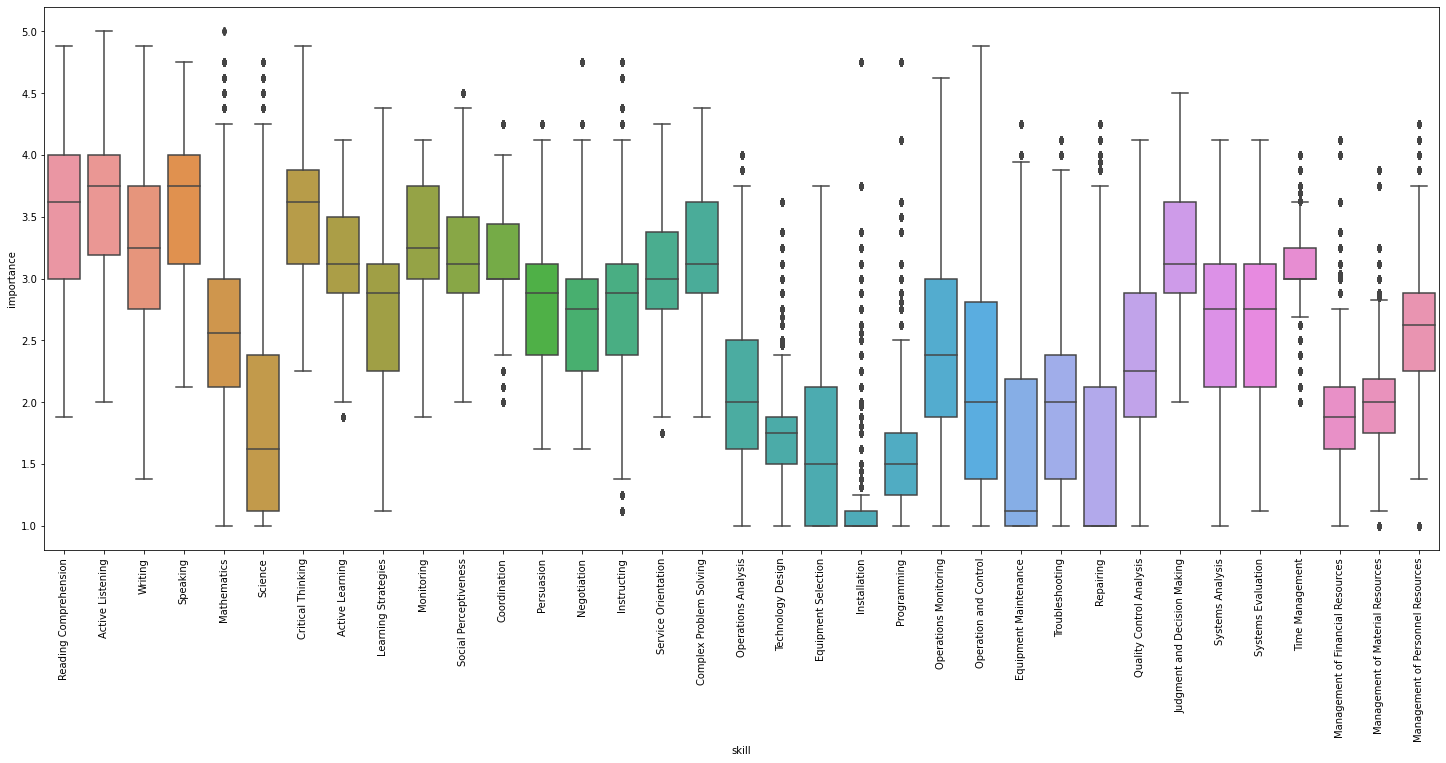

In [60]:
plt.subplots(figsize=(25,10))
sns.boxplot(x='skill', y='importance', data=df)
plt.xticks(rotation=90);

In [54]:
# Run a profile roport on final dataframe
final_profile = df.profile_report(html={'style': {'full_width': True}})
final_profile.to_widgets()

3 is the most common value for importance followed by 1. Whole values such as 3, 1, 2, and 4 are among the top 10 most frequent values which makes sense, given the tendacy to use whole numbers. The highest value, 5 is rare.

California, Texas and Florida have the highest number of jobs. These have more centers with high population density.

The annual salary skewed to the right indicating very few occupations earn above $150,000.

In [55]:
df.to_csv('../data/interim/salary_skill_cleaned.csv')